In [16]:
import pandas as pd
import pymc as pm
import numpy as np
# Get utils.py
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
# download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import set_pyplot_params

set_pyplot_params()

from utils import Or70, Pu50, Gr30

color_list3 = [Or70, Pu50, Gr30]

import matplotlib.pyplot as plt
from cycler import cycler

marker_cycle = cycler(marker=['s', 'o', '^'])
color_cycle = cycler(color=color_list3)
line_cycle = cycler(linestyle=['-', '--', ':'])

plt.rcParams['axes.prop_cycle'] = (color_cycle + 
                                   marker_cycle + 
                                   line_cycle)

# Load the data files from 
# https://github.com/allisonhorst/palmerpenguins
# With gratitude to Allison Horst (@allison_horst)

# download('https://github.com/allisonhorst/palmerpenguins/raw/main/inst/extdata/penguins_raw.csv')

In [3]:

df = pd.read_csv('penguins_raw.csv').dropna(subset=['Body Mass (g)'])
df.shape

(342, 17)

In [4]:
def shorten(species):
    return species.split()[0]

df['Species2'] = df['Species'].apply(shorten)

In [7]:
df.columns

Index(['studyName', 'Sample Number', 'Species', 'Region', 'Island', 'Stage',
       'Individual ID', 'Clutch Completion', 'Date Egg', 'Culmen Length (mm)',
       'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex',
       'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Comments', 'Species2'],
      dtype='object')

In [15]:
X = df[['Culmen Length (mm)', 'Flipper Length (mm)']]
y = df['Species2']
y, species = pd.factorize(df['Species2'], sort = True)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [22]:
X

,Culmen Length (mm),Flipper Length (mm)
0,39.1,181.0
1,39.5,186.0
2,40.3,195.0
4,36.7,193.0
5,39.3,190.0
...,...,...
339,55.8,207.0
340,43.5,202.0
341,49.6,193.0
342,50.8,210.0


In [17]:
with pm.Model() as model:
    # 데이터 컨테이너 설정
    X_data = pm.Data('X_data', X)
    # Y의 사전확률을 베타분포로 설정
    alpha = np.ones(3)
    p = pm.Dirichlet('p', alpha, shape=3)
    # Y의 베르누이 분포
    y = pm.Categorical('y', p, observed=y)
    # 각 클래스 및 특징(평균, 표준편차)에 대한 조건부 분포 설정
    mus = pm.Normal('mus', mu=0, sigma=10, shape=(3, 2))  
    sigmas = pm.HalfNormal('sigmas', sigma=1, shape=(3, 2))
    # 특징 데이터의 조건부 분포: Y에 따라 평균과 표준편차 선택
    X_obs = pm.Normal('X_obs'
                        , mu=mus[y]
                        , sigma=sigmas[y]
                        , observed=X_data)
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, mus, sigmas]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 4 seconds.


['Culmen Length (mm)', 'Flipper Length (mm)']

In [38]:
new_X

,Culmen Length (mm),Flipper Length (mm)
0,193,48


In [37]:
# 새로운 데이터
new_X = pd.DataFrame([[193, 48]],columns = X.columns)
with model:
    # 데이터 업데이트
    pm.set_data({'X_data': new_X})
    # 사후 예측 샘플링
    posterior_predictive = pm.sample_posterior_predictive(trace)
    y_pred_samples = posterior_predictive['y']
# 예측 결과
from scipy.stats import mode
y_pred = mode(y_pred_samples, axis=0).mode[0]
print(f"Predicted label for new X = [3, 5.2, 9] is {y_pred}")

Sampling: [X_obs, y]


Output()

ValueError: Output size (1, 2) is not compatible with broadcast dimensions of inputs (342, 2).
Apply node that caused the error: normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17CF8B760>), MakeVector{dtype='int64'}.0, 11, AdvancedSubtensor1.0, AdvancedSubtensor1.0)
Toposort index: 6
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(2,)), TensorType(int64, shape=()), TensorType(float64, shape=(None, None)), TensorType(float64, shape=(None, None))]
Inputs shapes: ['No shapes', (2,), (), (342, 2), (342, 2)]
Inputs strides: ['No strides', (8,), (), (16, 8), (16, 8)]
Inputs values: [Generator(PCG64) at 0x17CF8B760, array([1, 2]), array(11), 'not shown', 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

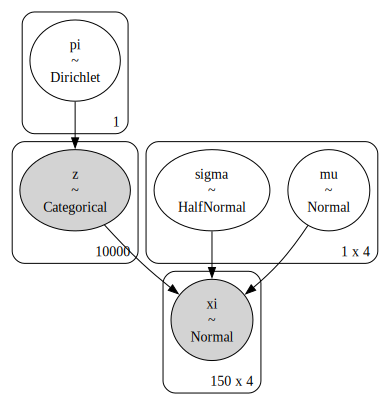

In [13]:
with pm.Model() as model:
    # Priors
    alpha = np.ones(1)
    pi = pm.Dirichlet('pi', alpha, shape=1)
    mu = pm.Normal('mu', mu=0, sigma=100, shape=(1, # num_cats
                                                4)) # num_preds
    sigma = pm.HalfNormal('sigma', 100, shape=(1,
                                                4))
    # Assign classes to data points
    z = pm.Categorical('z', pi, shape=10000,
                        observed=y)

    # The components are independent and normally distributed
    xi = pm.Normal('xi', mu=mu[z], sigma=sigma[z], observed=X)

pm.model_to_graphviz(model)